<div style="width: 1350px; height: 30px; background-color: green;"></div>


# 0. Load Modules

Convert to py:

`jupyter nbconvert --to script RCNN_crossval.ipynb`

In [65]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

# Data Transformation and Augmentation (not all of these transformations were finally used)
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, \
    RandomVerticalFlip, ColorJitter, RandomAffine, RandomPerspective, RandomResizedCrop, \
    GaussianBlur, RandomAutocontrast
from torchvision.transforms import functional as F

# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import HTML

# Miscellaneous
import random
from tqdm import tqdm

In [66]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    folder0_path = '/content/drive/My Drive/solar_jets/data0'
    folder1_path = '/content/drive/My Drive/solar_jets/data1'

    # Julie
    folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'
    folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_test'
    folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_test'
    folder0_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'
    folder1_valid_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'
else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'
    folder0_valid_path = './data0_val'
    folder1_valid_path = './data1_val'



## 1.1. Prepare the dataset

#### Create the class

In [4]:
class TensorTransforms:
    def __init__(self, rotate_angle=30):
        self.rotate_angle = rotate_angle

    def random_horizontal_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [2])  # Flip along width
        return x

    def random_vertical_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [1])  # Flip along height
        return x

    def random_rotation(self, x):
        # Random rotation in increments of 90 degrees for simplicity
        k = random.randint(0, 3)  # 0, 90, 180, or 270 degrees
        return torch.rot90(x, k, [1, 2])  # Rotate along height and width

    def __call__(self, x):
        x = self.random_horizontal_flip(x)
        x = self.random_vertical_flip(x)
        x = self.random_rotation(x)
        return x

class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=True, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = TensorTransforms()
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension

        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor

        if self.augment: #way to improve is to add to the data
            data = self.transform(data) #there we should concatenate both data and data_transformed

        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        label = 1.0 if 'data1' in self.data_dir else 0.0

        return data, np.float32(label)

#### Run to get the Data

We calculated the mean and std previously with function compute_mean_std

In [5]:
mean_data = 50.564544677734375
std_data = 49.94772720336914

In [6]:
train_data1 = NPZDataset(folder1_path, mean=mean_data, std=std_data, augment=True)
train_data0 = NPZDataset(folder0_path, mean=mean_data, std=std_data, augment=True)
train_dataset = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, mean=mean_data, std=std_data, augment=False)
test_data0 = NPZDataset(folder0_test_path, mean=mean_data, std=std_data, augment=False)
test_dataset = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, mean=mean_data, std=std_data, augment=False)
valid_data0 = NPZDataset(folder0_valid_path, mean=mean_data, std=std_data, augment=False)
validate_dataset = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

#### Divide train, validate, and test data

In [7]:
print("train: ",len(train_dataset))
print("validate: ",len(validate_dataset))
print("test: ",len(test_dataset))

train:  1200
validate:  252
test:  260


DataLoader is designed to iterate over batches of data rather than individual samples, so when we try to access for example the first mini-batch as `train_loader[0]`, we get an error.

However, note how before we could iterate over it


# 2. Define the Neural Network

In [8]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=256, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32,1),
            #nn.Sigmoid()     # don't include it as it is already included in BCELogitLoss (BCELoss is less stable)
        )

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

# 3. Cross validation

## 3.1 Training script

In [106]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, device, threshold):
    model.train()
    correct, train_loss, total_length = 0, 0, 0

    for i, (data, target) in enumerate(train_loader):

        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        data, target = data.to(device), target.to(device).unsqueeze(1).float()

        #FORWARD PASS
        output = model(data)
        loss = criterion(output, target)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # PREDICTIONS
        pred = (torch.sigmoid(output) >= threshold).float()

        # PERFORMANCE CALCULATION
        train_loss += loss.item() * len(data)
        total_length += len(data)
        correct += pred.eq(target.view_as(pred)).sum().item()

    
    scheduler.step()
    train_loss = train_loss / total_length
    train_acc = correct / total_length

    return train_loss, train_acc, scheduler.get_last_lr()[0]

## 3.2 Validation scripts

In [107]:
def predict(model, train_loader, criterion, device, threshold):
    model.eval()
    correct, val_loss, total_length = 0, 0, 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in train_loader:

            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float()

            # PERFORMANCE CALCULATION
            val_loss += loss.item() * len(data)
            total_length += len(data)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    val_loss = val_loss / total_length
    val_acc = correct / total_length

    return val_loss, val_acc, np.array(all_preds), np.array(all_targets)


def test(model, train_loader, criterion, device, threshold):
    model.eval()
    correct, val_loss, total_length = 0, 0, 0
    all_preds = []
    all_targets = []
    all_out = []

    with torch.no_grad():
        for data, target in train_loader:

            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data, target = data.to(device), target.to(device).unsqueeze(1).float()

            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target)
            # PREDICTIONS
            pred = (torch.sigmoid(output) >= threshold).float()

            # PERFORMANCE CALCULATION
            val_loss += loss.item() * len(data)
            total_length += len(data)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())
            all_out.extend(output.view(-1).cpu().numpy())

    val_loss = val_loss / total_length
    val_acc = correct / total_length

    return val_loss, val_acc, np.array(all_preds), np.array(all_targets), np.array(all_out)

In [109]:
import json #to store the final dictionnary
#hyperparameters remaining constant for cross-validation, will be updated after it
num_epochs = 100
batch_size = 2
weight_decay = 5e-3
threshold = 0.5
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#Define hyperparameter crossvalidation
initial_lr = [
    1e-3#,
    #1e-4
]

optimizers = [
    #{'optimizer': torch.optim.SGD, 'weight_decay': weight_decay, 'momentum': 0.9, 'nesterov': True},
    {'optimizer': torch.optim.AdamW, 'weight_decay': weight_decay}
]

schedulers = [
    #torch.optim.lr_scheduler.ExponentialLR,
    torch.optim.lr_scheduler.CosineAnnealingLR
    #torch.optim.lr_scheduler.ReduceLROnPlateau
]

# Store the results of the cross_validation in a dictionnary
a=0
results_dict={}

#loop
for lr in initial_lr: 
    for optimizer_params in optimizers:
        for scheduler_type in schedulers:

            #1. initialize the model
            model = RCNN()
            model.to(device)

            #2. Define Optimizer
            optimizer_class = optimizer_params['optimizer']
            optimizer_kwargs = {key: value for key, value in optimizer_params.items() if key != 'optimizer'}

            optimizer = optimizer_class(model.parameters(), lr=lr, **optimizer_kwargs)

            #3. Define Scheduler
            if scheduler_type==torch.optim.lr_scheduler.ExponentialLR:
                scheduler_params= dict(
                    gamma=0.9
                )

            elif scheduler_type==torch.optim.lr_scheduler.CosineAnnealingLR:
                scheduler_params= dict(
                    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size
                )

            elif scheduler_type==torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler_params= dict(
                    mode='min',
                    factor=0.1,
                    patience=10,
                    threshold=1e-4,
                    threshold_mode='rel',
                    cooldown=0,
                    min_lr=0,
                    eps=1e-8,
                    verbose=False
                )
            else:
                print(f"problem with the scheduler :{scheduler_type}")
                exit()

            scheduler = scheduler_type(optimizer, **scheduler_params)

            # Logs results
            loss_history_train=[]
            lr_history_train=[]
            acc_history_train=[]

            acc_history_test=[]
            loss_history_test=[]

            f1_val_history = []

            print(f"Start of the training model {a+1} over 2")

            # Loop to update and record learning rate
            for epoch in range(1,num_epochs+1):
                # Train
                train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, device, threshold)
                loss_history_train.append(train_loss)
                acc_history_train.append(train_acc)
                lr_history_train.append(lrs)

                # Validate
                val_loss, val_acc, val_preds, val_targets = predict(model, valid_loader, criterion, device, threshold)
                loss_history_test.append(val_loss)
                acc_history_test.append(val_acc)

                # Calculate F1 score on validation
                f1 = f1_score(val_targets, val_preds, average='binary')  # adjust the average parameter as needed
                f1_val_history.append(f1)

                if epoch == 50:
                    print(f"epoch 50: valid acc ={acc_history_test[-1]}, f1 val = {f1_val_history[-1]}")
                
                if epoch == 100:
                    print(f"epoch 100: valid acc ={acc_history_test[-1]}, f1 val = {f1_val_history[-1]}")

            #Calculate results on test set
            test_loss, test_accuracy, test_predictions, test_targets, test_out = test(model, test_loader, criterion, device, threshold)
            test_f1_score = f1_score(test_targets, test_predictions, average='binary')
            print(f"test acc ={test_accuracy}, f1 test = {test_f1_score}")

            #store results in a dictionnary

            # Hyperparameters on iteration a
            param_name = f"hyperparams_{a}"
            results_dict[param_name] = [str(lr), str(scheduler_type), str(optimizer_params['optimizer'])]

            #Accuracy on train set (100 values per model)
            acc_train_name = f"acc_train_{a}"
            results_dict[acc_train_name] = acc_history_train

            #F1 score on validation set (100 values)
            f1_valid_name = f"f1_valid_{a}"
            results_dict[f1_valid_name] = f1_val_history

            #F1 score on test set (1 value)
            f1_test_name = f"f1_test_{a}"
            results_dict[f1_test_name] = test_f1_score

            #update variable
            a+=1

with open('result_cv_lr.json', 'w') as file:
    json.dump(results_dict, file)


cuda
Start of the training model 1 over 2
epoch 50: valid acc =0.5, f1 val = 0.6666666666666666


KeyboardInterrupt: 

In [ ]:
print(np.max(f1_val_history))
print(test_f1_score)

## if needed modify the value "a" for json

In [77]:
with open("result_cv_final.json", 'r') as file:
    data1 = json.load(file)
print(data1.keys())

dict_keys(['hyperparams_0', 'acc_train_0', 'f1_valid_0', 'f1_test_0', 'hyperparams_1', 'acc_train_1', 'f1_valid_1', 'f1_test_1', 'hyperparams_6', 'acc_train_6', 'f1_valid_6', 'f1_test_6', 'hyperparams_7', 'acc_train_7', 'f1_valid_7', 'f1_test_7', 'hyperparams_9', 'acc_train_9', 'f1_valid_9', 'f1_test_9', 'hyperparams_10', 'acc_train_10', 'f1_valid_10', 'f1_test_10', 'hyperparams_12', 'acc_train_12', 'f1_valid_12', 'f1_test_12', 'hyperparams_13', 'acc_train_13', 'f1_valid_13', 'f1_test_13', 'hyperparams_15', 'acc_train_15', 'f1_valid_15', 'f1_test_15', 'hyperparams_16', 'acc_train_16', 'f1_valid_16', 'f1_test_16', 'hyperparams_8', 'acc_train_8', 'f1_valid_8', 'f1_test_8', 'hyperparams_11', 'acc_train_11', 'f1_valid_11', 'f1_test_11', 'hyperparams_114', 'acc_train_114', 'f1_valid_114', 'f1_test_114', 'hyperparams_17', 'acc_train_17', 'f1_valid_17', 'f1_test_17', 'hyperparams_3', 'acc_train_3', 'f1_valid_3', 'f1_test_3', 'hyperparams_4', 'acc_train_4', 'f1_valid_4', 'f1_test_4', 'hyperpar

In [78]:
#original_dict = updated_dict
original_dict = data1
# Specify the substring to replace and the replacement
substring_to_replace = '_114'
replacement = '_14'

# Create a new dictionary with updated keys
updated_dict = {key.replace(substring_to_replace, replacement): value for key, value in original_dict.items()}

print(updated_dict.keys())

dict_keys(['hyperparams_0', 'acc_train_0', 'f1_valid_0', 'f1_test_0', 'hyperparams_1', 'acc_train_1', 'f1_valid_1', 'f1_test_1', 'hyperparams_6', 'acc_train_6', 'f1_valid_6', 'f1_test_6', 'hyperparams_7', 'acc_train_7', 'f1_valid_7', 'f1_test_7', 'hyperparams_9', 'acc_train_9', 'f1_valid_9', 'f1_test_9', 'hyperparams_10', 'acc_train_10', 'f1_valid_10', 'f1_test_10', 'hyperparams_12', 'acc_train_12', 'f1_valid_12', 'f1_test_12', 'hyperparams_13', 'acc_train_13', 'f1_valid_13', 'f1_test_13', 'hyperparams_15', 'acc_train_15', 'f1_valid_15', 'f1_test_15', 'hyperparams_16', 'acc_train_16', 'f1_valid_16', 'f1_test_16', 'hyperparams_8', 'acc_train_8', 'f1_valid_8', 'f1_test_8', 'hyperparams_11', 'acc_train_11', 'f1_valid_11', 'f1_test_11', 'hyperparams_14', 'acc_train_14', 'f1_valid_14', 'f1_test_14', 'hyperparams_17', 'acc_train_17', 'f1_valid_17', 'f1_test_17', 'hyperparams_3', 'acc_train_3', 'f1_valid_3', 'f1_test_3', 'hyperparams_4', 'acc_train_4', 'f1_valid_4', 'f1_test_4', 'hyperparams_

In [79]:
with open('result_cv_final.json', 'w') as file:
    json.dump(updated_dict, file)

## if needed merge json files

In [71]:
# Load content from the first JSON file
file1="result_cv_3.json"
file2="result_cv_last.json"


with open(file1, 'r') as file:
    data1 = json.load(file)

# Load content from the second JSON file
with open(file2, 'r') as file:
    data2 = json.load(file)

# Merge dictionaries
merged_dict = {**data1, **data2}

# Print or do something with the merged dictionary
print(merged_dict.keys())

# Save the merged dictionary to a new JSON file if needed
with open('result_cv_final.json', 'w') as file:
    json.dump(merged_dict, file, indent=2)

dict_keys(['hyperparams_0', 'acc_train_0', 'f1_valid_0', 'f1_test_0', 'hyperparams_1', 'acc_train_1', 'f1_valid_1', 'f1_test_1', 'hyperparams_6', 'acc_train_6', 'f1_valid_6', 'f1_test_6', 'hyperparams_7', 'acc_train_7', 'f1_valid_7', 'f1_test_7', 'hyperparams_9', 'acc_train_9', 'f1_valid_9', 'f1_test_9', 'hyperparams_10', 'acc_train_10', 'f1_valid_10', 'f1_test_10', 'hyperparams_12', 'acc_train_12', 'f1_valid_12', 'f1_test_12', 'hyperparams_13', 'acc_train_13', 'f1_valid_13', 'f1_test_13', 'hyperparams_15', 'acc_train_15', 'f1_valid_15', 'f1_test_15', 'hyperparams_16', 'acc_train_16', 'f1_valid_16', 'f1_test_16', 'hyperparams_8', 'acc_train_8', 'f1_valid_8', 'f1_test_8', 'hyperparams_11', 'acc_train_11', 'f1_valid_11', 'f1_test_11', 'hyperparams_114', 'acc_train_114', 'f1_valid_114', 'f1_test_114', 'hyperparams_17', 'acc_train_17', 'f1_valid_17', 'f1_test_17', 'hyperparams_3', 'acc_train_3', 'f1_valid_3', 'f1_test_3', 'hyperparams_4', 'acc_train_4', 'f1_valid_4', 'f1_test_4', 'hyperpar

In [72]:
with open("result_cv_final.json", 'r') as file:
    data1 = json.load(file)
print(len(data1.keys())/4)

18.0


# Plots With the result dictionnary

### Import and read the json file

In [110]:
#We have one value of f1_test, 100 values of f1_valid and acc_train for each model (18)
#Plots f1 score (y) against epochs=np.arange(1,101) (x), 18 lines as 18 models (maybe reduce it by initial learning rate)


json_file_path = 'result_cv_final.json'

# Open the JSON file and load the data into a Python dictionary
with open(json_file_path, 'r') as file:
    result_dict = json.load(file)

# Now, 'data_dictionary' contains the content of your JSON file as a Python dictionary
print(result_dict)
a = int(len(result_dict) / 4)


{'hyperparams_0': ['0.0001', "<class 'torch.optim.lr_scheduler.ExponentialLR'>", "<class 'torch.optim.sgd.SGD'>"], 'acc_train_0': [0.6025, 0.62, 0.6541666666666667, 0.6741666666666667, 0.6975, 0.7208333333333333, 0.715, 0.7241666666666666, 0.7391666666666666, 0.7566666666666667, 0.7658333333333334, 0.7491666666666666, 0.765, 0.7733333333333333, 0.7866666666666666, 0.7941666666666667, 0.78, 0.7966666666666666, 0.7858333333333334, 0.79, 0.8075, 0.805, 0.7883333333333333, 0.7891666666666667, 0.7991666666666667, 0.8125, 0.8166666666666667, 0.8091666666666667, 0.8041666666666667, 0.8041666666666667, 0.8225, 0.8108333333333333, 0.8108333333333333, 0.8066666666666666, 0.7966666666666666, 0.8133333333333334, 0.8191666666666667, 0.8191666666666667, 0.8233333333333334, 0.8125, 0.83, 0.8316666666666667, 0.8233333333333334, 0.825, 0.82, 0.8166666666666667, 0.8116666666666666, 0.8275, 0.8225, 0.8283333333333334, 0.8283333333333334, 0.8258333333333333, 0.8191666666666667, 0.8233333333333334, 0.82083

In [81]:
result_dict.keys()

dict_keys(['hyperparams_0', 'acc_train_0', 'f1_valid_0', 'f1_test_0', 'hyperparams_1', 'acc_train_1', 'f1_valid_1', 'f1_test_1', 'hyperparams_6', 'acc_train_6', 'f1_valid_6', 'f1_test_6', 'hyperparams_7', 'acc_train_7', 'f1_valid_7', 'f1_test_7', 'hyperparams_9', 'acc_train_9', 'f1_valid_9', 'f1_test_9', 'hyperparams_10', 'acc_train_10', 'f1_valid_10', 'f1_test_10', 'hyperparams_12', 'acc_train_12', 'f1_valid_12', 'f1_test_12', 'hyperparams_13', 'acc_train_13', 'f1_valid_13', 'f1_test_13', 'hyperparams_15', 'acc_train_15', 'f1_valid_15', 'f1_test_15', 'hyperparams_16', 'acc_train_16', 'f1_valid_16', 'f1_test_16', 'hyperparams_8', 'acc_train_8', 'f1_valid_8', 'f1_test_8', 'hyperparams_11', 'acc_train_11', 'f1_valid_11', 'f1_test_11', 'hyperparams_14', 'acc_train_14', 'f1_valid_14', 'f1_test_14', 'hyperparams_17', 'acc_train_17', 'f1_valid_17', 'f1_test_17', 'hyperparams_3', 'acc_train_3', 'f1_valid_3', 'f1_test_3', 'hyperparams_4', 'acc_train_4', 'f1_valid_4', 'f1_test_4', 'hyperparams_

In [98]:
def get_param(result_dict, i):

    hyperparams_name = f"hyperparams_{i}"
    hyperparams = result_dict[hyperparams_name]

    lr = hyperparams[0]
    scheduler_type = hyperparams[1]

    if scheduler_type == "<class 'torch.optim.lr_scheduler.ExponentialLR'>":
      scheduler_type = 'Exponential LR'

    elif scheduler_type == "<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>":
      scheduler_type = 'Cosine annealing LR'

    elif scheduler_type == "<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>":
      scheduler_type = 'Reduce LR on plateau'

    optimizer = hyperparams[2]

    if optimizer == "<class 'torch.optim.sgd.SGD'>":
      optimizer = 'SGD'

    elif optimizer ==  "<class 'torch.optim.adamw.AdamW'>":
      optimizer = 'Adam'

    return lr, scheduler_type, optimizer

### Plot the F1 score of the validation set (all 18 lines)

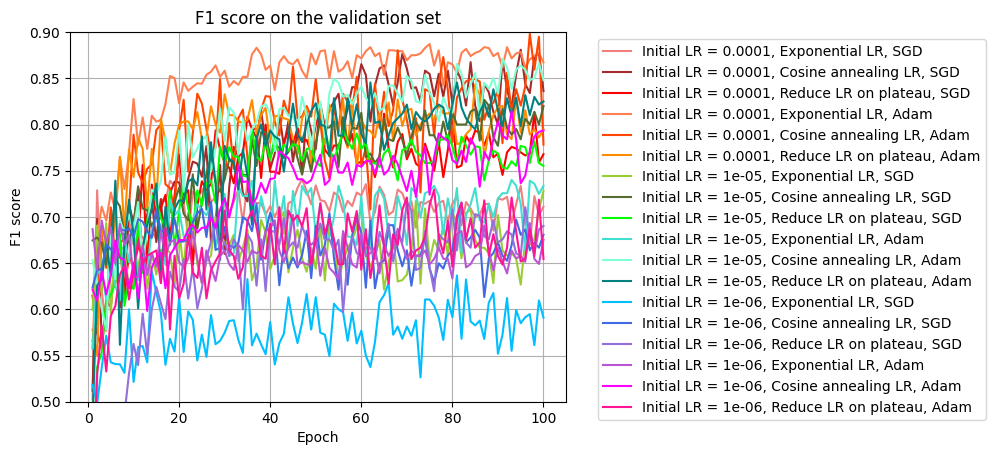

In [99]:
t_test = np.arange(1, num_epochs + 1)
clr_lst = ['lightcoral', 'brown', 'red', 'coral', 'orangered', 'darkorange',
           'yellowgreen', 'darkolivegreen', "lime", "turquoise", "aquamarine", "teal",
            'deepskyblue', 'royalblue', 'mediumpurple', 'mediumorchid', 'fuchsia', 'deeppink']

fig, axs = plt.subplots()
axs.grid(True)

for i in range(a):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs.plot(t_test, f1_vals, color=clr_lst[i], label= "Initial LR = " + lr + ", " + scheduler_type + ", " + optimizer)

axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs.set_title('F1 score on the validation set')
axs.set_xlabel('Epoch')
axs.set_ylabel('F1 score')
axs.set_ylim(0.5, 0.9)

plt.show()

### Plot the F1 score of the validation set (1 graph per learning rate)

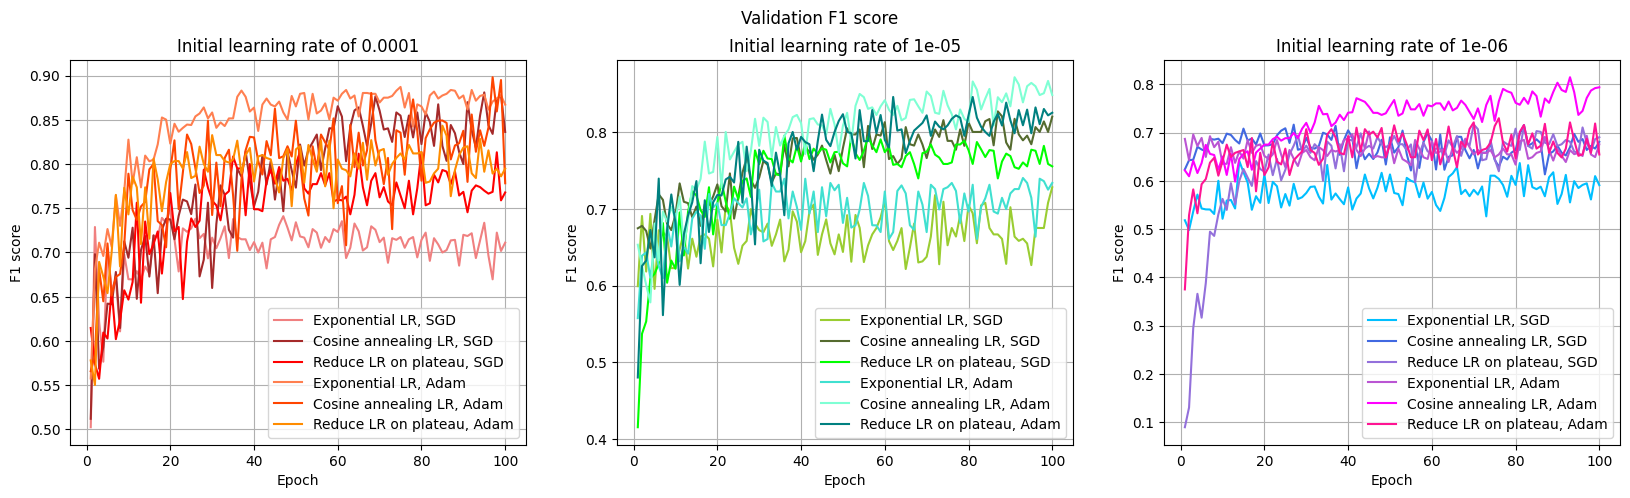

In [100]:
t_test = np.arange(1, num_epochs + 1)
clr_lst = ['lightcoral', 'brown', 'red', 'coral', 'orangered', 'darkorange',
           'yellowgreen', 'darkolivegreen', "lime", "turquoise", "aquamarine", "teal",
            'deepskyblue', 'royalblue', 'mediumpurple', 'mediumorchid', 'fuchsia', 'deeppink']

lr_set = set()

for i in range(a):
    hyperparams_name = f"hyperparams_{i}"
    hyperparams = result_dict[hyperparams_name]

    lr_set.add(str(hyperparams[0]))

if len(lr_set) == 1:

  fig, axs = plt.subplots()

  for i in range(a):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs.plot(t_test, f1_vals, color=clr_lst[i], label= lr + ", " + scheduler_type + ", " + optimizer)

  axs.legend()
  axs.set_title('F1 score on the validation set')
  axs.set_xlabel('Epoch')
  axs.set_ylabel('F1 score')

  plt.show()

elif len(lr_set) == 2:

  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle('Validation F1 score')

  for i in range(int(a/2)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[0].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[0].grid(True)
  axs[0].legend()
  axs[0].set_title(f'Initial learning rate of {1e-4}')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('F1 score')

  for i in range(int(a/2), int(a)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[1].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[1].grid(True)
  axs[1].legend()
  axs[1].set_title(f'Initial learning rate of {1e-5}')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('F1 score')

  plt.show()

elif len(lr_set) == 3:

  fig, axs = plt.subplots(1, 3, figsize=(20, 5))
  fig.suptitle('Validation F1 score')

  for i in range(int(a/3)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[0].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[0].grid(True)
  axs[0].legend()
  axs[0].set_title(f'Initial learning rate of {1e-4}')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('F1 score')

  for i in range(int(a/3), int(2*a/3)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[1].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[1].grid(True)
  axs[1].legend()
  axs[1].set_title(f'Initial learning rate of {1e-5}')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('F1 score')


  for i in range(int(2*a/3), int(3*a/3)):
    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[2].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[2].grid(True)
  axs[2].legend()
  axs[2].set_title(f'Initial learning rate of {1e-6}')
  axs[2].set_xlabel('Epoch')
  axs[2].set_ylabel('F1 score')

  plt.show()




# Get best parameters

In [115]:
max_valid=0
max_test=0
val_index=0
test_intex=0
for i in range(18):
    f1_valid_name = f"f1_valid_{i}"
    f1_test_name = f"f1_test_{i}"

    max_valid_one=np.max(result_dict[f1_valid_name])
    max_test_one=np.max(result_dict[f1_test_name])
    epoch=np.argmax(result_dict[f1_valid_name])

    if max_valid_one>max_valid:
        max_valid=max_valid_one
        val_index=i
        epoch_val=epoch
        
    
    if max_test_one>max_test:
        max_test=max_test_one
        test_index=i

best_para_valid=f"hyperparams_{val_index}"
best_para_test=f"hyperparams_{test_index}"


print(f"max f1 score of valid set is {max_valid} with {result_dict[best_para_valid]} at epoch {epoch_val+1}")
print(f"max f1 score of test set is {max_test} with {result_dict[best_para_test]}")

max f1 score of valid set is 0.8981132075471698 with ['0.0001', "<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>", "<class 'torch.optim.adamw.AdamW'>"] at epoch 97
max f1 score of test set is 0.8996282527881041 with ['0.0001', "<class 'torch.optim.lr_scheduler.ExponentialLR'>", "<class 'torch.optim.adamw.AdamW'>"]


In [116]:
#best model : a=3
max_valid=0
max_test=0
val_index=0
test_intex=0

i=3
f1_valid_name = f"f1_valid_{i}"
f1_test_name = f"f1_test_{i}"

max_valid_one=np.max(result_dict[f1_valid_name])
max_test_one=np.max(result_dict[f1_test_name])
epoch=np.argmax(result_dict[f1_valid_name])

if max_valid_one>max_valid:
        max_valid=max_valid_one
        val_index=i
        epoch_val=epoch
        
    
if max_test_one>max_test:
        max_test=max_test_one
        test_index=i

best_para_valid=f"hyperparams_{val_index}"
best_para_test=f"hyperparams_{test_index}"


print(f"max f1 score of valid set is {max_valid} with {result_dict[best_para_valid]} at epoch {epoch_val+1}")
print(f"max f1 score of test set is {max_test} with {result_dict[best_para_test]}")

max f1 score of valid set is 0.8871595330739299 with ['0.0001', "<class 'torch.optim.lr_scheduler.ExponentialLR'>", "<class 'torch.optim.adamw.AdamW'>"] at epoch 75
max f1 score of test set is 0.8996282527881041 with ['0.0001', "<class 'torch.optim.lr_scheduler.ExponentialLR'>", "<class 'torch.optim.adamw.AdamW'>"]


# Plot Accuracy of train set (see if overfit)

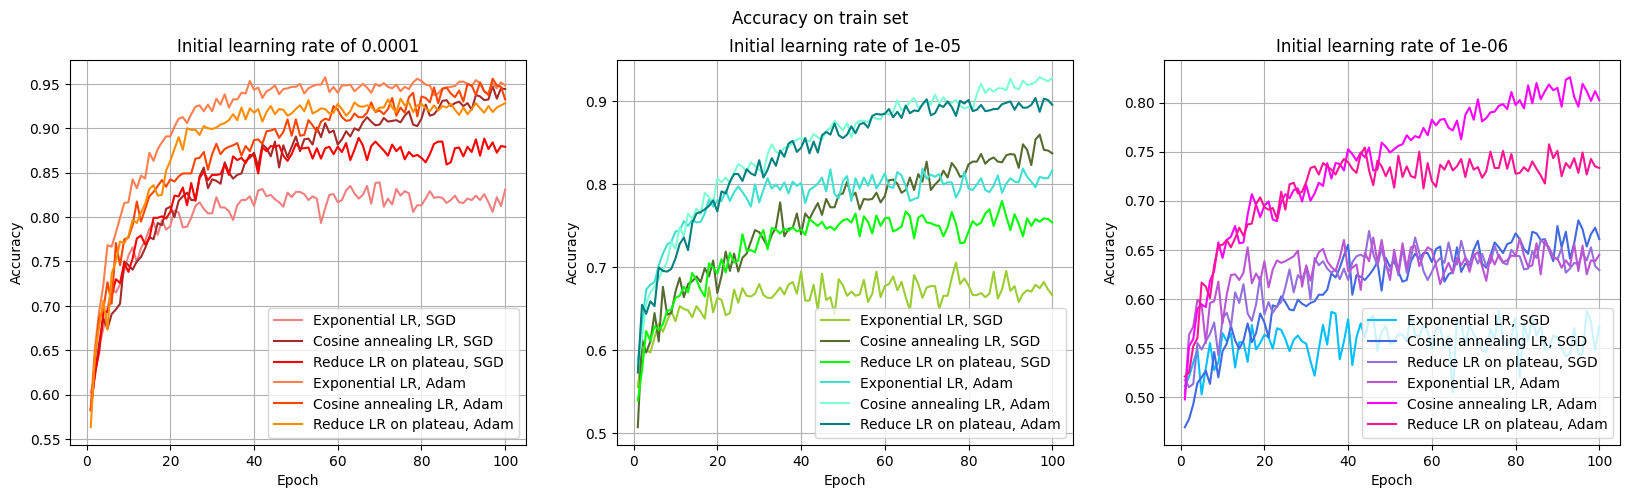

In [111]:
t_test = np.arange(1, num_epochs + 1)
clr_lst = ['lightcoral', 'brown', 'red', 'coral', 'orangered', 'darkorange',
           'yellowgreen', 'darkolivegreen', "lime", "turquoise", "aquamarine", "teal",
            'deepskyblue', 'royalblue', 'mediumpurple', 'mediumorchid', 'fuchsia', 'deeppink']

lr_set = set()

for i in range(a):
    hyperparams_name = f"hyperparams_{i}"
    hyperparams = result_dict[hyperparams_name]

    lr_set.add(str(hyperparams[0]))

if len(lr_set) == 1:

  fig, axs = plt.subplots()

  for i in range(a):
    f1_valid_name = f"acc_train_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs.plot(t_test, f1_vals, color=clr_lst[i], label= lr + ", " + scheduler_type + ", " + optimizer)

  axs.legend()
  axs.set_title('Accuracy on train set')
  axs.set_xlabel('Epoch')
  axs.set_ylabel('Accuracy')

  plt.show()

elif len(lr_set) == 2:

  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle('Accuracy on train set')

  for i in range(int(a/2)):

    f1_valid_name = f"acc_train_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[0].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[0].grid(True)
  axs[0].legend()
  axs[0].set_title(f'Initial learning rate of {1e-4}')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('F1 score')

  for i in range(int(a/2), int(a)):

    f1_valid_name = f"f1_valid_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[1].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[1].grid(True)
  axs[1].legend()
  axs[1].set_title(f'Initial learning rate of {1e-5}')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')

  plt.show()

elif len(lr_set) == 3:

  fig, axs = plt.subplots(1, 3, figsize=(20, 5))
  fig.suptitle('Accuracy on train set')

  for i in range(int(a/3)):

    f1_valid_name = f"acc_train_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[0].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[0].grid(True)
  axs[0].legend()
  axs[0].set_title(f'Initial learning rate of {1e-4}')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')

  for i in range(int(a/3), int(2*a/3)):

    f1_valid_name = f"acc_train_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[1].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[1].grid(True)
  axs[1].legend()
  axs[1].set_title(f'Initial learning rate of {1e-5}')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')


  for i in range(int(2*a/3), int(3*a/3)):
    f1_valid_name = f"acc_train_{i}"
    f1_vals = result_dict[f1_valid_name]

    lr, scheduler_type, optimizer = get_param(result_dict, i)

    axs[2].plot(t_test, f1_vals, color=clr_lst[i], label= scheduler_type + ", " + optimizer)

  axs[2].grid(True)
  axs[2].legend()
  axs[2].set_title(f'Initial learning rate of {1e-6}')
  axs[2].set_xlabel('Epoch')
  axs[2].set_ylabel('Accuracy')

  plt.show()
